# Web3 Trading Team — Data Science Assignment (Full Notebook)

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

## Load Datasets

In [ ]:
historical_path = "historical_data.csv"
fg_path = "fear_greed_index.csv"

# === 3. Load CSVs ===
def safe_read_csv(path):
    for enc in [None, "utf-8", "latin1", "cp1252"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise ValueError(f"Cannot read CSV file: {path}")

hist = safe_read_csv(historical_path)
fg = safe_read_csv(fg_path)

print("✅ Files loaded successfully!")
print("Historical shape:", hist.shape)
print("Fear/Greed shape:", fg.shape,"\n")
print("Historical columns:\n", hist.columns,"\n")
print("Fear/Greed columns:\n", fg.columns)


✅ Files loaded successfully!
Historical shape: (211224, 16)
Fear/Greed shape: (2644, 4) 

Historical columns:
 Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object') 

Fear/Greed columns:
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


## Data Cleaning & Preprocessing

In [ ]:
def detect_column(df, keywords):
    for col in df.columns:
        if any(kw.lower() in col.lower() for kw in keywords):
            return col
    return None

date_col_hist = detect_column(hist, ["time", "date", "timestamp"])
account_col = detect_column(hist, ["account", "trader", "user"])
size_col = detect_column(hist, ["size", "volume", "qty", "quantity"])
pnl_col = detect_column(hist, ["pnl", "profit", "loss"])
leverage_col = detect_column(hist, ["leverage", "lev"])

print("\nDetected columns:")
print(f"Date: {date_col_hist}, Account: {account_col}, Size: {size_col}, PnL: {pnl_col}, Leverage: {leverage_col}")

hist[date_col_hist] = pd.to_datetime(hist[date_col_hist], errors='coerce')
hist["date"] = hist[date_col_hist].dt.floor("D")

for c in [size_col, pnl_col, leverage_col]:
    if c in hist.columns:
        hist[c] = pd.to_numeric(hist[c], errors="coerce")


Detected columns:
Date: Timestamp IST, Account: Account, Size: Size Tokens, PnL: Closed PnL, Leverage: None


## Daily Aggregations

In [ ]:
agg = hist.groupby("date").agg(
    total_trades=("Account", "count") if "Account" in hist.columns else (hist.columns[0], "count"),
    unique_accounts=(account_col, pd.Series.nunique) if account_col else (hist.columns[0], "count"),
    total_volume=(size_col, "sum") if size_col else (hist.columns[0], "count"),
    avg_leverage=(leverage_col, "mean") if leverage_col else (size_col, "mean"),
    total_closedPnL=(pnl_col, "sum") if pnl_col else (hist.columns[0], "count"),
).reset_index()

## Fear & Greed processing

In [ ]:
fg["date"] = pd.to_datetime(fg["date"], errors="coerce")
class_col = detect_column(fg, ["class", "fear", "greed"])
fg["sentiment"] = fg[class_col].astype(str).str.strip()

## Merge and summarize

In [ ]:
merged = pd.merge(agg, fg[["date", "sentiment"]], on="date", how="left")
merged["sentiment"] = merged["sentiment"].fillna("Unknown")

sent_summary = merged.groupby("sentiment").agg(
    days=("date", "count"),
    avg_daily_trades=("total_trades", "mean"),
    avg_daily_volume=("total_volume", "mean"),
    avg_daily_leverage=("avg_leverage", "mean"),
    avg_daily_pnl=("total_closedPnL", "mean"),
).reset_index()

display(sent_summary)


,sentiment,days,avg_daily_trades,avg_daily_volume,avg_daily_leverage,avg_daily_pnl
0,Extreme Fear,6,387.666667,9.536770e+05,927.009157,733.322758
1,Extreme Greed,43,130.720930,2.144779e+06,23912.586574,26904.504083
2,Fear,37,374.837838,1.206927e+06,12007.338134,48087.177910
3,Greed,56,201.642857,3.015824e+06,23803.944526,10886.295226
4,Neutral,16,172.250000,3.052417e+06,17594.360681,4666.046374
5,Unknown,30,1445.366667,3.920386e+06,2825.341977,68471.885438


## Save outputs

In [ ]:
os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

agg.to_csv("csv_files/daily_aggregates.csv", index=False)
merged.to_csv("csv_files/daily_aggregates_with_sentiment.csv", index=False)
sent_summary.to_csv("csv_files/sentiment_level_aggregates.csv", index=False)

# Visualizations

## Correlation Matrix

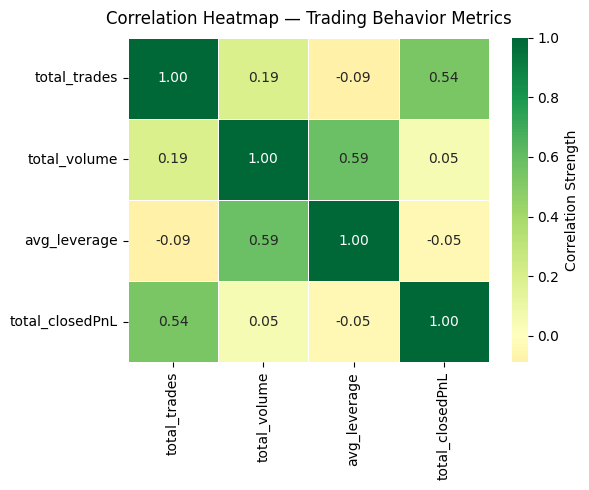

In [ ]:
from IPython.display import display, HTML

numeric_cols = ["total_trades", "total_volume", "avg_leverage", "total_closedPnL"]
corr = merged[numeric_cols].corr()

display(HTML('<h2 style="color:white;">Correlation Matrix:</h2>'))


# Professional heatmap visualization
plt.figure(figsize=(6,5))
sns.heatmap(
    corr,
    annot=True,
    cmap="RdYlGn",        # red → yellow → green gradient
    center=0,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={"label": "Correlation Strength"}
)
plt.title("Correlation Heatmap — Trading Behavior Metrics", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig("outputs/correlation_heatmap_colored.png")
plt.show()


## Total PnL over time

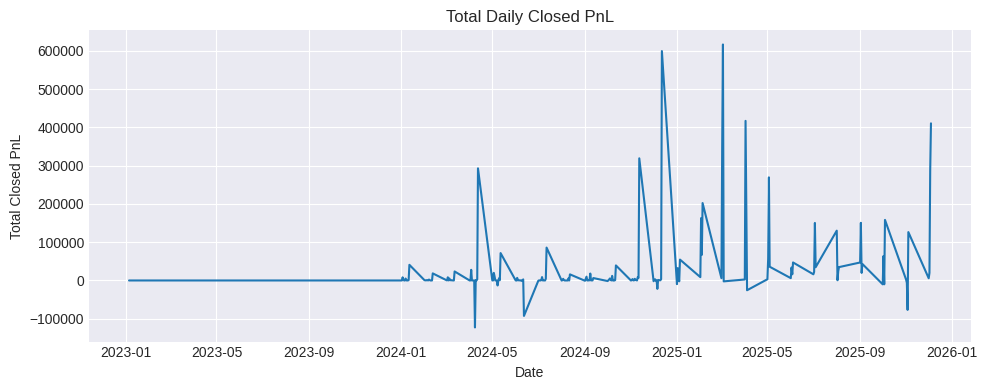

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")


plt.figure(figsize=(10,4))
plt.plot(merged["date"], merged["total_closedPnL"], color="tab:blue")
plt.title("Total Daily Closed PnL")
plt.xlabel("Date")
plt.ylabel("Total Closed PnL")
plt.tight_layout()
plt.savefig("outputs/daily_total_closedPnL.png")
plt.show()

## Avg leverage over time

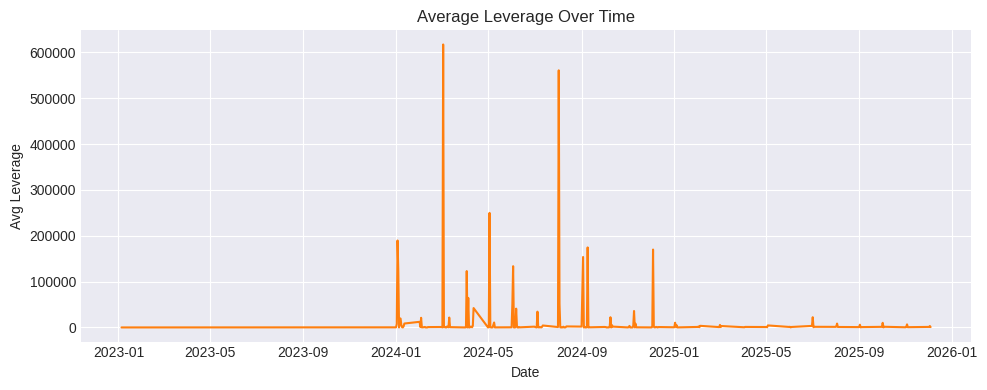

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(merged["date"], merged["avg_leverage"], color="tab:orange")
plt.title("Average Leverage Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Leverage")
plt.tight_layout()
plt.savefig("outputs/daily_avg_leverage.png")
plt.show()

## Avg PnL by sentiment

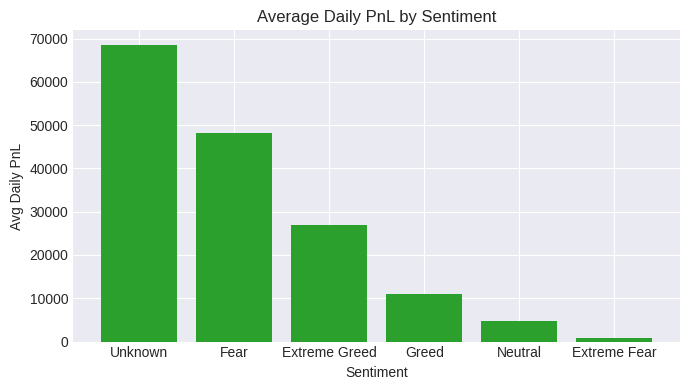

In [ ]:
plt.figure(figsize=(7,4))
sent_plot = sent_summary.sort_values("avg_daily_pnl", ascending=False)
plt.bar(sent_plot["sentiment"], sent_plot["avg_daily_pnl"], color="tab:green")
plt.title("Average Daily PnL by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Avg Daily PnL")
plt.tight_layout()
plt.savefig("outputs/avg_daily_pnl_by_sentiment.png")
plt.show()

## Rolling averages: PnL & leverage

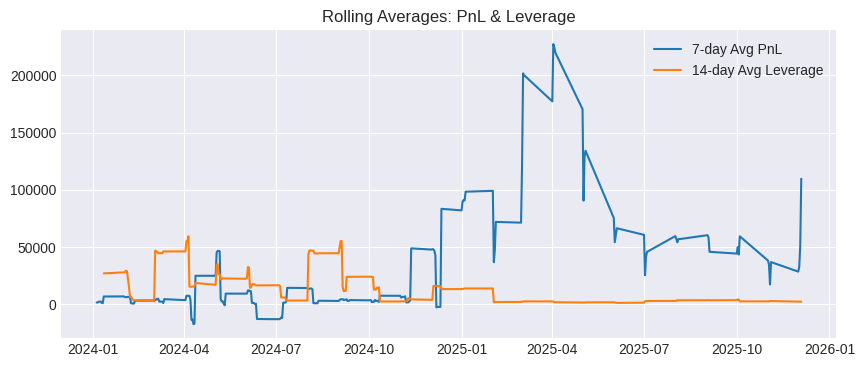

In [ ]:
if leverage_col and pnl_col and "sentiment" in merged.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(data=hist, x=leverage_col, kde=True, bins=30)
    plt.title("Distribution of Leverage")
    plt.savefig("outputs/distribution_leverage.png")
    plt.show()

    plt.figure(figsize=(8,5))
    sns.histplot(data=hist, x=pnl_col, kde=True, bins=30)
    plt.title("Distribution of PnL")
    plt.savefig("outputs/distribution_pnl.png")
    plt.show()

    if size_col:
        plt.figure(figsize=(8,5))
        sns.histplot(data=hist, x=size_col, kde=True, bins=30)
        plt.title("Distribution of Trade Size")
        plt.savefig("outputs/distribution_size.png")
        plt.show()

if leverage_col and pnl_col in hist.columns:
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=hist, x=leverage_col, y=pnl_col, alpha=0.6)
    plt.title("Leverage vs Closed PnL")
    plt.savefig("outputs/leverage_vs_pnl.png")
    plt.show()

merged = merged.sort_values("date")
merged["pnl_7d_avg"] = merged["total_closedPnL"].rolling(7).mean()
merged["leverage_14d_avg"] = merged["avg_leverage"].rolling(14).mean()

plt.figure(figsize=(10,4))
plt.plot(merged["date"], merged["pnl_7d_avg"], label="7-day Avg PnL")
plt.plot(merged["date"], merged["leverage_14d_avg"], label="14-day Avg Leverage")
plt.title("Rolling Averages: PnL & Leverage")
plt.legend()
plt.savefig("outputs/rolling_averages.png")
plt.show()


## Account-level analysis


🏆 Top 10 Accounts by Avg PnL:


,Account,total_trades,avg_pnl,win_rate
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,383,520.902331,0.234987
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,419.127768,0.359612
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1237,336.735548,0.484236
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1430,281.826227,0.306294
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,1590,270.034947,0.345912
24,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,417,174.691809,0.573141
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,332,161.133275,0.475904
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,4356,155.589314,0.486226
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14733,145.481748,0.337134
25,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,563,120.507317,0.408526


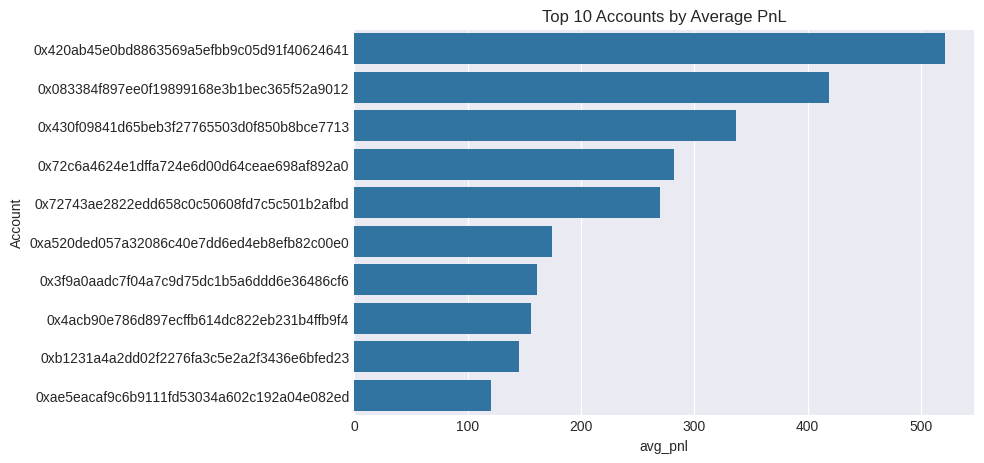

In [ ]:
if account_col and pnl_col:
    account_summary = hist.groupby(account_col).agg(
        total_trades=("Account", "count"),
        avg_pnl=(pnl_col, "mean"),
        win_rate=(pnl_col, lambda x: (x > 0).mean())
    ).reset_index()
    top_accounts = account_summary.sort_values("avg_pnl", ascending=False).head(10)

    print("\n🏆 Top 10 Accounts by Avg PnL:")
    display(top_accounts)

    print("")

    plt.figure(figsize=(8,5))
    sns.barplot(x="avg_pnl", y=account_col, data=top_accounts)
    plt.title("Top 10 Accounts by Average PnL")
    plt.savefig("outputs/top_accounts_avg_pnl.png")
    plt.show()

## Predictive insight

In [ ]:
merged["sentiment_binary"] = merged["sentiment"].map({"Greed":1, "Fear":0})
corr_signal = merged[["sentiment_binary","avg_leverage","total_closedPnL"]].corr()

print("\n🔍 Predictive insight Check (Correlation):")
display(corr_signal)


🔍 Predictive insight Check (Correlation):


,sentiment_binary,avg_leverage,total_closedPnL
sentiment_binary,1.000000,0.085154,-0.202340
avg_leverage,0.085154,1.000000,-0.045663
total_closedPnL,-0.202340,-0.045663,1.000000


In [ ]:
print("\n✅ Analysis complete! All outputs saved in:")
print("📂 csv_files/")
print("📂 outputs/")


✅ Analysis complete! All outputs saved in:
📂 csv_files/
📂 outputs/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')